In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.image as mpimg
from matplotlib import patches
import pandas as pd

from astropy import table, units as u, coordinates, cosmology, wcs
from astropy.io import fits

from astroquery.mast import Catalogs
from astroquery.skyview import SkyView

from ekfobs import planning
from ekfphys import observer, calibrations
from ekfplot import plot as ek
from ekfparse import query

from agrias import utils
from skipper import observe

import sys
sys.path.append('../scripts')
import reader, VAST_coordination

cosmo = cosmology.FlatLambdaCDM(70., 0.3)

In [4]:
merian = table.Table(fits.getdata("/Users/kadofong/Downloads/Merian_DR1_photoz_EAZY_v2.0.fits", 1))#.to_pandas ()
ms = reader.merianselect ( merian, maglim=25.,)

/Users/kadofong/work/projects/merian/agrias/notebooks/reader.py:31: RuntimeWarning: invalid value encountered in log10
  n708mag = -2.5*np.log10(mertab[bu.photcols['N708']]) + zp


[merianselect] Only choosing sources at 0.060<z_phot<0.100
[merianselect] Only choosing sources with m_i < 25.0
[merianselect] only choosing sources with cmodel/gaap(i) > 1.3


/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [45]:
lmc_stellarmass = 2.7e9
is_lmcmass = abs(ms['logmass'] - np.log10(lmc_stellarmass)) < 0.25

lmcs = ms.loc[is_lmcmass]

In [5]:
voids = pd.read_table(
    '../../../literature_ref/SDSS/VoidCatalogs/7406035/VoidFinder-nsa_v1_0_1_Planck2018_comoving_holes.txt', 
    comment='#',
    delim_whitespace=True,
    names=['x','y','z','radius','void']
)

#maximal = pd.read_table(
#    '../../../literature_ref/SDSS/VoidCatalogs/7406035/VoidFinder-nsa_v1_0_1_Planck2018_comoving_maximal.txt',
#    comment='#',
#    delim_whitespace=True,
#    names=['x','y','z','radius','void','edge','r','ra','dec','Reff']
#)

In [28]:
from astropy import constants as co
from astropy.io import fits

In [63]:
boss_voids = table.Table.read(
    '../../../literature_ref/SDSS/VoidCatalogs/Mao2017/table1.dat',
    readme='../../../literature_ref/SDSS/VoidCatalogs/Mao2017/ReadMe',
    format='cds'
)
                              

In [69]:
void_coords = coordinates.SkyCoord(boss_voids['RAdeg'], boss_voids['DEdeg'], distance=cosmo.comoving_distance(boss_voids['z']))

In [33]:
galaxy_coords = coordinates.SkyCoord(ms['RA'].values*u.deg, ms['DEC'].values*u.deg, distance=cosmo.comoving_distance(ms['redshift']))

In [72]:
zgrid = np.linspace(0.06,0.1,10)
arr = np.zeros([len(zgrid),len(lmcs)])
for zdx, z in enumerate(zgrid):
    lmcs['redshift'] = z
    #galaxy_coords = VAST_coordination.ra_dec_to_xyz(lmcs,h=1.)
    galaxy_coords = coordinates.SkyCoord(
        lmcs['RA'].values*u.deg, 
        lmcs['DEC'].values*u.deg, 
        distance=cosmo.comoving_distance(lmcs['redshift'])
    ) 
    for idx in range(len(lmcs)):
        #d2voidcenter = np.sqrt((voids['x'] - galaxy_coords[idx,0])**2 + (voids['y']-galaxy_coords[idx,1])**2 + (voids['z']-galaxy_coords[idx,2])**2)
        d2voidcenter = galaxy_coords[0].separation_3d(void_coords).to(u.Mpc).value
        #in_void = d2voidcenter<voids['radius']
        in_void = d2voidcenter < boss_voids['Reff']
        if in_void.any():
            arr[zdx, idx] = 1

    break

/var/folders/fs/f3k7bp2n3k1bldhn58thddt40000gn/T/ipykernel_36061/3685151716.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lmcs['redshift'] = z


In [77]:
boss_voids['z'].min()

0.214

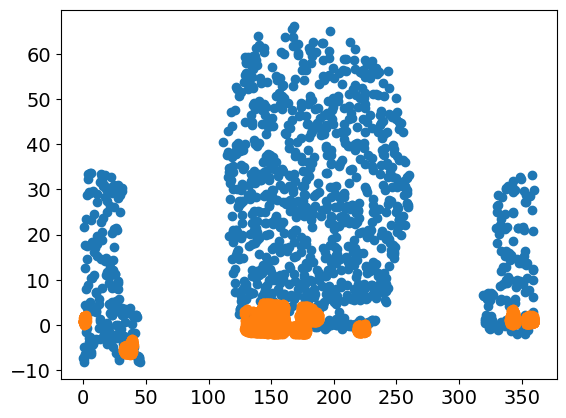

In [66]:
plt.scatter(
    boss_voids['RAdeg'],
    boss_voids['DEdeg'],
)
plt.scatter(
    lmcs['RA'],
    lmcs['DEC']
)

In [7]:
p_invoid = arr.sum(axis=0) / arr.shape[0]
probably_void = p_invoid > 0.75

In [9]:
ms.loc[probably_void&is_lmcmass].to_csv('/Users/kadofong/Desktop/void_lmc_analogs.csv')

In [10]:
void_parent = parent.loc[probably_void]

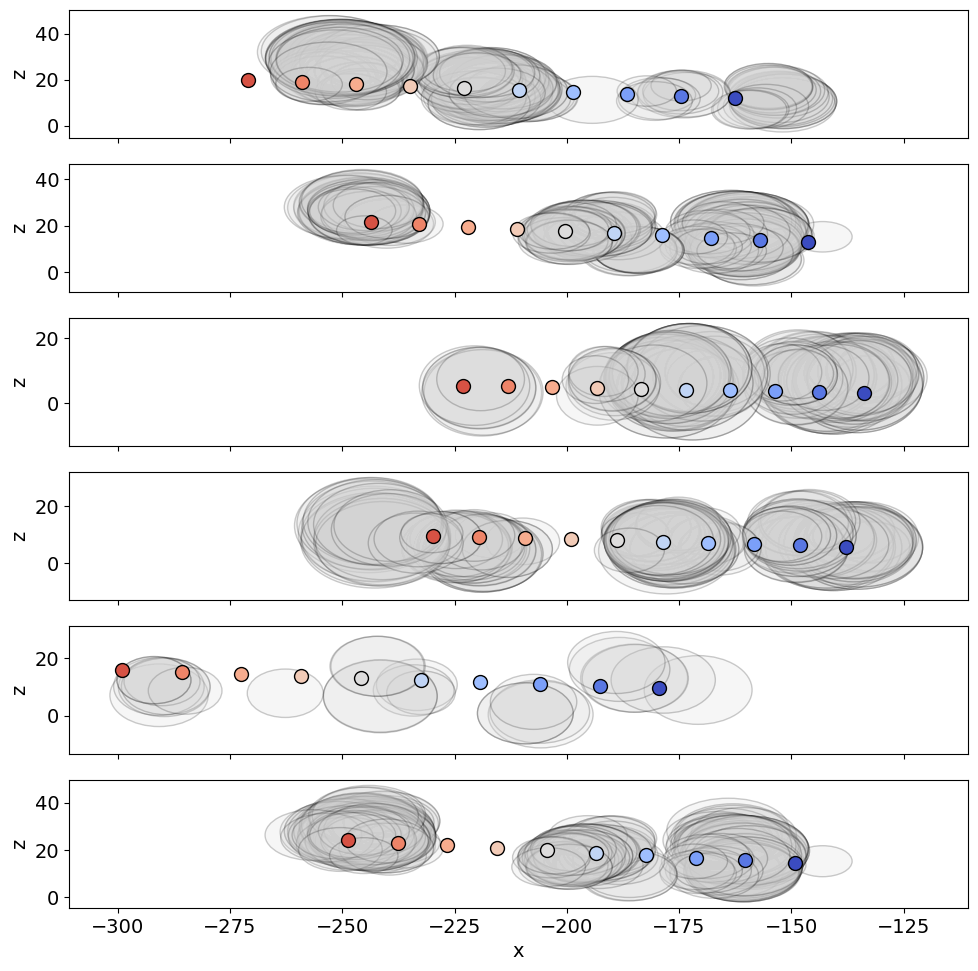

In [11]:
fig,axarr = plt.subplots(6,1,figsize=(10,10), sharex=True)


for axidx in range(axarr.shape[0]):
    ax = axarr[axidx]
    idx = np.random.randint(0, probably_void.sum())
    for zdx, z in enumerate(zgrid):
        ms['redshift'] = z
        galaxy_coords = VAST_coordination.ra_dec_to_xyz(ms.loc[probably_void],h=1.)
        
        #for idx in range(len(ms)):
        d2voidcenter = np.sqrt((voids['x'] - galaxy_coords[idx,0])**2 + (voids['y']-galaxy_coords[idx,1])**2 + (voids['z']-galaxy_coords[idx,2])**2)
        intersecting_void = voids.loc[d2voidcenter<voids['radius']]
        
        for _,row in intersecting_void.iterrows():
            circ = patches.Circle((row.x,row.z), radius=row['radius'], facecolor='lightgrey', alpha=0.2, edgecolor='k')
            ax.add_patch(circ)
        
        ax.scatter ( galaxy_coords[idx,0], galaxy_coords[idx,2], color = plt.cm.coolwarm(zdx/zgrid.size), s=10**2, edgecolor='k', zorder=10 )   

plt.xlabel('x')
for ax in axarr:
    ax.set_ylabel('z')

plt.tight_layout ()   
plt.savefig('/Users/kadofong/Desktop/high_probability_void.png')

In [15]:
sample_name = 'LMCVoids'
if not os.path.exists(sample_name):
    os.mkdir(sample_name)

for dirname in  ['thumbnails','cutouts','finding_charts']:
    dpath = f'{sample_name}/{dirname}'
    if not os.path.exists(dpath):
        os.mkdir(dpath)

In [13]:
palomar = observe.ObservingSite('palomar')
lco = observe.ObservingSite('CTIO')

In [14]:
night_start, night_end = lco.get_sunriseset ( 2024, 8, 29, )
obsframe = palomar.define_obsframe ( obs_start=night_start, obs_end=night_end )

coords = coordinates.SkyCoord(*parent.loc[:, ['RA','DEC']].values.T, unit='deg')
alt_l = [ palomar.get_altitude(cc, obsframe) for cc in coords ]

is_observable = np.array([ np.nanmin(np.where(x.secz<0, 10.,x.secz)).value<1.4 for x in alt_l ])
sample = parent.loc[is_observable]
print(sample.shape)

[observe] Computing sunrise and sunset on 2024/9/5 at altitude = -14.0


(0, 75)


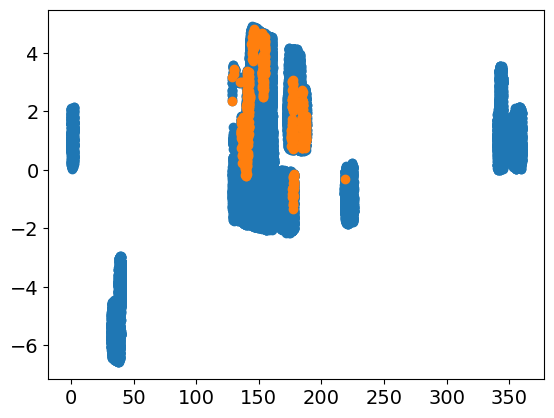

In [16]:
plt.scatter ( ms.loc[:,'RA'], ms.loc[:,'DEC'] )
plt.scatter ( parent['RA'], parent['DEC'])
plt.scatter ( parent.loc[is_observable,'RA'], parent.loc[is_observable,'DEC'] )


In [21]:
dlum = cosmo.luminosity_distance(0.1).to(u.cm).value
lha_expected = calibrations.SFR2LHa(10.**sample['logsfr']) 
fha_expected = lha_expected / (4.*np.pi*dlum**2)
r_absmag = utils.flux2mag(sample['r_cModelFlux_Merian']) - cosmo.distmod(0.08).value
ewha_expected = calibrations.EWfromLHa(lha_expected, r_absmag, )


In [10]:
ostars = planning.find_blindoffset_stars(coords[is_observable], maglim=17)

INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


In [11]:
for idx in range(len(sample)):
    target = sample.iloc[idx]
    query.get_legacysurveyimage(
        target['RA'], target['DEC'], 
        savedir=f'./{sample_name}/thumbnails/', savename=sample.index[idx], pixscale=0.26, width=200, height=200, format='jpg'
    )


Saving:
https://www.legacysurvey.org/viewer/cutout.jpg?ra=33.222069613082795&dec=-6.431757352571157&layer=ls-dr9&pixscale=0.26&width=200&height=200
to ./MassComplete/thumbnails/M2950244784020665799.jpg
Saving:
https://www.legacysurvey.org/viewer/cutout.jpg?ra=34.87384196984972&dec=-6.144657254871133&layer=ls-dr9&pixscale=0.26&width=200&height=200
to ./MassComplete/thumbnails/M2950675792578767836.jpg
Saving:
https://www.legacysurvey.org/viewer/cutout.jpg?ra=34.92193960012602&dec=-6.112787900648346&layer=ls-dr9&pixscale=0.26&width=200&height=200
to ./MassComplete/thumbnails/M2950675792578772244.jpg
Saving:
https://www.legacysurvey.org/viewer/cutout.jpg?ra=34.9175928620035&dec=-6.0497402078601175&layer=ls-dr9&pixscale=0.26&width=200&height=200
to ./MassComplete/thumbnails/M2950675792578778840.jpg
Saving:
https://www.legacysurvey.org/viewer/cutout.jpg?ra=33.62645933229555&dec=-6.137009770905149&layer=ls-dr9&pixscale=0.26&width=200&height=200
to ./MassComplete/thumbnails/M295070657890433827

In [12]:
for idx in range(len(sample)):
    ostar = ostars.iloc[idx]
    query.get_legacysurveyimage(ostar['ra'], ostar['dec'], savedir=f'./{sample_name}/cutouts/', 
                                savename=sample.index[idx], pixscale=1., width=300, height=300, verbose=False)

In [ ]:
for ridx in range(len(sample)):
    ostar = ostars.iloc[ridx]
    name = sample.index[ridx]
    cutout = fits.open(f'./{sample_name}/cutouts/{name}.fits')[0]
    cutout_wcs = wcs.WCS(cutout.header)
    
    row = sample.iloc[ridx]
    name = row.name
    
    fig = plt.figure(figsize=(13, 4))
    ax = fig.add_subplot(1,3,1)
    
    alt_l_index = np.arange(len(alt_l), dtype=int)[is_observable][ridx]
    ax.plot(obsframe.obstime.datetime, alt_l[alt_l_index].alt, 'o')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
    #ax.set_xtic(rotation=45)
    tw = ax.twinx()
    tw.plot(obsframe.obstime.datetime, alt_l[alt_l_index].secz, 'o', color='C1')
    tw.set_ylim(1.,3.)
    tw.set_ylabel('airmass', color='C1', rotation=270, labelpad=20)
    
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    ax.set_xlabel('Time [UTC]')
    ax.set_ylabel('altitude', color='C0')
    
    
    ek.text(
        0.025,
        0.975,
        r'%s' % row.name,
        ax=ax,
        fontsize=10,
        bordercolor='w',
        borderwidth=2
    )
    
    ax.spines.left.set_color("C0")

    
    ax=fig.add_axes(132, projection=cutout_wcs.celestial)
    ek.imshow(cutout.data[0],origin='lower', cmap='Greys', q=0.0025, ax=ax)
    
    msize = 20
    ek.celestial_plot(sample.iloc[ridx]['RA'], sample.iloc[ridx]['DEC'], ax, marker='o', markeredgecolor='lime', markerfacecolor='None', markersize=msize)
    ek.celestial_plot(ostar['ra'], ostar['dec'], ax, marker='o', markeredgecolor='cyan', markerfacecolor='None', markersize=msize)
    
    ek.text(0.025, 0.975, 'Offset Star', color='cyan', ax=ax, bordercolor='w', borderwidth=3)
    ek.text(0.025, 0.905, 'Science Target', color='lime', ax=ax, bordercolor='w', borderwidth=3)


    ras = [sample.iloc[ridx]['RA'], ostar['ra']]
    decs = [sample.iloc[ridx]['DEC'],ostar['dec']]
    ek.celestial_plot( ras, decs, ax, color='r', lw=0.2, ls=':' )
    ek.text(
        np.mean(ras),
        np.mean(decs),
        r"%i''" % ostar.distance_arcsec,
        color='tab:red',
        coord_type='absolute',
        bordercolor='w',
        borderwidth=2,
        transform=ax.get_transform('fk5'),
        ax=ax
    )
        
    
    ax.grid(color='white', ls=':')
    ax.set_xlabel('RA [J2000]')
    ax.set_ylabel('DEC [J2000]')
    

    imax = fig.add_axes(133)
    thumbnail = mpimg.imread(f'./{sample_name}/thumbnails/{name}.jpg')
    imax.imshow(thumbnail)
    imax.axis('off')
    fha = fha_from_sfr(row)
    fha_oom = np.floor(np.log10(fha))

    ek.text(
        0.025,
        0.975,
        r'''$m_r = %.1f$
$m_{N708}=%.1f$
$F_{\rm H\alpha}^{\rm est} = %.2f\times 10^{%i} \frac{\rm erg}{\rm s\ cm^{2}}$'''%(
            utils.flux2mag(row['r_cModelFlux_Merian']),
            utils.flux2mag(row['N708_cModelFlux_Merian']),
            fha / 10.**fha_oom,
            fha_oom
        ),
        ax=imax,
        color='w',
        fontsize=12
    )
    plt.tight_layout ()
    
    pos = imax.get_position ()
    new_pos = [pos.x0 - 0.1, pos.y0, pos.width, pos.height]
    imax.set_position (new_pos)

    plt.savefig(f'./{sample_name}/finding_charts/{name}.png')
    plt.close()

/var/folders/fs/f3k7bp2n3k1bldhn58thddt40000gn/T/ipykernel_87985/3282180528.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/var/folders/fs/f3k7bp2n3k1bldhn58thddt40000gn/T/ipykernel_87985/3282180528.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/var/folders/fs/f3k7bp2n3k1bldhn58thddt40000gn/T/ipykernel_87985/3282180528.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/var/folders/fs/f3k7bp2n3k1bldhn58thddt40000gn/T/ipykernel_87985/3282180528.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/var/folders/fs/f3k7bp2n3k1bldhn58thddt40000gn/T/ipykernel_87985/3282180528.py:23: UserWarning: FixedFormatter should only be used together with